# Importing data

In [1]:
# Input file location and name
input_file = 'data/loan.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
# Reading in the loan file and inspecting its shape
loan = pd.read_csv(input_file, low_memory=False)
print("Rows: %d, Columns: %d" % (loan.shape[0], loan.shape[1]))

Rows: 39717, Columns: 111


# Filtering Rows and Columns

In [4]:
# Dropping columns which are completely empty
loan = loan.dropna(axis='columns', how='all')
loan.shape

(39717, 57)

In [5]:
# The following columns only have 0s in them
# cols initial_list_status, application_type have only one value
empty_columns = ['collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 
                 'delinq_amnt', 'tax_liens', 'initial_list_status', 'application_type']
loan = loan.drop(empty_columns, axis='columns')
loan.shape

(39717, 50)

In [6]:
# The following fields will have entries only when the loan is
# defaulted, so removing them
# Some columns like 'next_pymnt_d' is applicable only to 'current'
# loan_status
irrel_columns = ['recoveries', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 
                 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                 'next_pymnt_d', 'url']
loan = loan.drop(irrel_columns, axis='columns')
loan.shape

(39717, 40)

In [7]:
# Removing 'Current' rows from the dataset since it is not possible to know 
# if they will default in the future
loan = loan[~(loan['loan_status'] == 'Current')]
loan.shape

(38577, 40)

In [8]:
# Also dropping member_id, since there are no repeating members
# and id will play the primary key
loan = loan.drop('member_id', axis='columns')
loan.shape

(38577, 39)

# Type conversions

In [9]:
# Converting int_rate to integer
loan['int_rate'] = pd.to_numeric(loan['int_rate'].str[:-1])
loan['int_rate'].dtype

dtype('float64')

In [10]:
# Parsing all datetime columns
date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
loan[date_columns] = loan[date_columns].apply(pd.to_datetime, format="%b-%y")
loan[date_columns].dtypes

issue_d               datetime64[ns]
earliest_cr_line      datetime64[ns]
last_pymnt_d          datetime64[ns]
last_credit_pull_d    datetime64[ns]
dtype: object

In [11]:
# list of categorical columns
cat_columns = ['grade', 'sub_grade', 'home_ownership',
              'verification_status', 'loan_status', 'pymnt_plan',
              'purpose', 'zip_code', 'addr_state']
loan[cat_columns] = loan[cat_columns].apply(lambda x: x.astype('category'))
loan[cat_columns].dtypes

grade                  category
sub_grade              category
home_ownership         category
verification_status    category
loan_status            category
pymnt_plan             category
purpose                category
zip_code               category
addr_state             category
dtype: object

In [12]:
# Explicitly setting order for a categorical column
loan['emp_length'] = pd.Categorical(loan['emp_length'], categories=['< 1 year', '1 year','2 years', '3 years',      
                                                '4 years', '5 years', '6 years', '7 years', 
                                                '8 years', '9 years', '10+ years'], ordered=True)
loan['emp_length'].dtype

CategoricalDtype(categories=['< 1 year', '1 year', '2 years', '3 years', '4 years',
                  '5 years', '6 years', '7 years', '8 years', '9 years',
                  '10+ years'],
                 ordered=True)

# Derived columns creation

In [13]:
# Creating Year from date column
loan['Year_issued'] = loan['issue_d'].dt.year

# Imputation

# Univariate and Value Treatment

## Purpose

In [14]:
# No missing values
loan['purpose'].describe()

count                  38577
unique                    14
top       debt_consolidation
freq                   18055
Name: purpose, dtype: object

## Annual Income

In [15]:
# looking at the distribution
loan['annual_inc'].describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

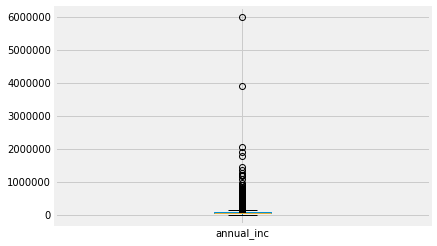

In [16]:
# Clearly it has values which skew the whole column
loan['annual_inc'].plot(kind='box')
plt.show()

In [17]:
# Creating a new column by eliminating the outliers
# 95 percentile set as limit
loan['annual_inc_treat'] = np.where(loan['annual_inc'] < loan['annual_inc'].quantile(.95), 
                                    loan['annual_inc'], np.nan)

## Issue Date

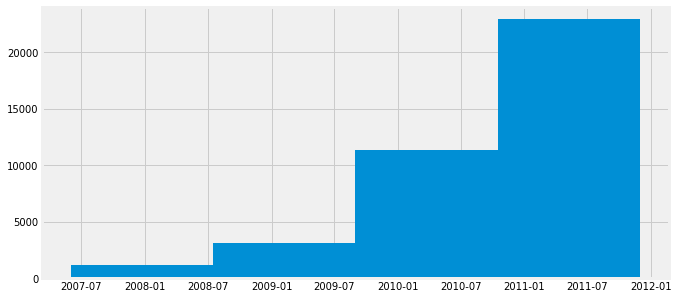

In [18]:
# The distribution is uniform within a year
loan['issue_d'].hist(bins=4, figsize=(10,5))
plt.show()

## Emp Length

In [19]:
# Has missing values
loan['emp_length'].describe()

count         37544
unique           11
top       10+ years
freq           8488
Name: emp_length, dtype: object

## Interest Rate

In [20]:
loan['int_rate'].describe()

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64

## Term

In [21]:
loan['term'].describe()

count          38577
unique             2
top        36 months
freq           29096
Name: term, dtype: object

## State

In [22]:
# No missing values
loan['addr_state'].describe()

count     38577
unique       50
top          CA
freq       6949
Name: addr_state, dtype: object

## Grade

In [23]:
# Grade has 7 levels wiht no NAs
loan['grade'].describe()

count     38577
unique        7
top           B
freq      11675
Name: grade, dtype: object

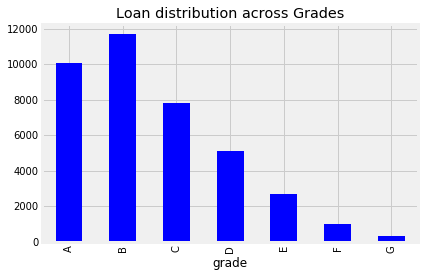

In [24]:
# loans for the grades are unequally distributed
loan.groupby('grade')['id'].count().plot(kind='bar', color='blue')
plt.title('Loan distribution across Grades')
plt.show()

## Debt to Income Ratio

In [25]:
# No missing values
loan['dti'].describe()

count    38577.000000
mean        13.272727
std          6.673044
min          0.000000
25%          8.130000
50%         13.370000
75%         18.560000
max         29.990000
Name: dti, dtype: float64

## Sub Grade

In [26]:
# No NAs, 5 levels within each Grade
loan['sub_grade'].describe()

count     38577
unique       35
top          A4
freq       2873
Name: sub_grade, dtype: object

## Home Ownership

In [27]:
# No missing values
loan['home_ownership'].describe()

count     38577
unique        5
top        RENT
freq      18480
Name: home_ownership, dtype: object

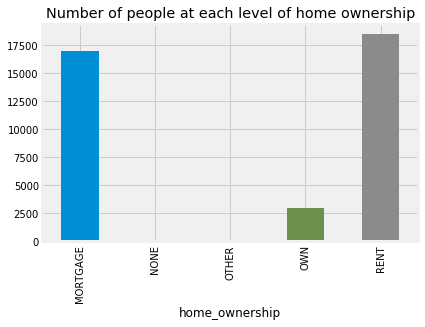

In [28]:
# Distribution across home ownership
loan.groupby('home_ownership')['id'].count().plot(kind='bar')
plt.title('Number of people at each level of home ownership')
plt.show()

## Open Account

In [29]:
loan['open_acc'].describe()

count    38577.000000
mean         9.275423
std          4.401588
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

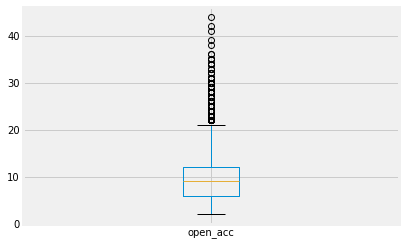

In [30]:
loan['open_acc'].plot(kind='box')

## Delinquency in 2 yrs

In [31]:
# Highly skewed
loan['delinq_2yrs'].describe()

count    38577.000000
mean         0.146668
std          0.492271
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: delinq_2yrs, dtype: float64

In [32]:
# almost 90% of people have 0
loan['delinq_2yrs'].value_counts()

0     34386
1      3207
2       673
3       212
4        60
5        21
6        10
7         4
8         2
11        1
9         1
Name: delinq_2yrs, dtype: int64

## Inquiry in the last 6 months

In [33]:
loan['inq_last_6mths'].describe()

count    38577.000000
mean         0.871737
std          1.071546
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64

In [34]:
loan['inq_last_6mths'].value_counts()

0    18709
1    10660
2     5654
3     2983
4      316
5      144
6       63
7       34
8       14
Name: inq_last_6mths, dtype: int64

# Univariate Segmented

# Bivariate

## Helper Functions

In [35]:
# HELPER, for plotting two distributions on the same axis
def double_dist(df, column, title):
    # Filtering charged off loans and plotting hist
    temp = df[df['loan_status'] == 'Charged Off'][column]
    temp.hist(alpha=0.5, density=True, figsize=(8, 5), color='red')
    # Filtering fully paid loans and plotting hist
    temp = df[df['loan_status'] == 'Fully Paid'][column]
    temp.hist(alpha=0.5, density=True, figsize=(8, 5), color='green')
    plt.title(title)
    plt.legend(('Charged Off', 'Fully Paid'))
    plt.show()

In [36]:
# HELPER, for plotting normalized stacked bar
def stacked_bar(df, column, title, top=None, size=(15, 5)):
    # Data Prep
    temp = loan.groupby([column, 'loan_status'])['id'].count().reset_index()
    temp = temp.pivot_table(index=column, columns='loan_status', values='id')
    temp = temp.fillna(0)
    total = temp['Charged Off'] + temp['Fully Paid']
    temp['Charged Off'] = temp['Charged Off']/total
    temp['Fully Paid'] = temp['Fully Paid']/total
    if top is not None:
        temp = temp.sort_values('Charged Off', ascending=False)[:top]

    # Plotting the stacked bar
    plt.figure(figsize=size)
    temp['Fully Paid'].plot(kind='bar', color='green', label='Fully Paid')
    temp['Charged Off'].plot(kind='bar', bottom=temp['Fully Paid'], color='red', 
                                         label='Charged Off')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15,1))
    plt.title(title)
    plt.show()

In [37]:
# HELPER, for plotting double bar graph
def dual_bar(df, column, title):
    # Data preparation for plot
    temp = df.groupby(['loan_status', column])['id'].count().reset_index()
    temp = temp.pivot_table(index=column, columns='loan_status', values='id')
    temp['Charged Off'] = temp['Charged Off']/temp['Charged Off'].sum()
    temp['Fully Paid'] = temp['Fully Paid']/temp['Fully Paid'].sum()

    # Plotting figure
    temp.plot(kind='bar', figsize=(10,5))
    plt.ylabel('Normalized distribution of count')
    plt.legend(loc="upper left")
    plt.title(title)
    plt.show()

## Term vs Loan Status
**Hypothesis:** Loan with high duration tend to default

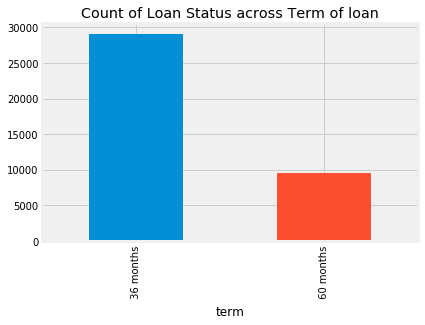

In [38]:
loan.groupby('term')['loan_status'].count().plot(kind='bar')
plt.title("Count of Loan Status across Term of loan")
plt.show()

## Interest Rate vs Loan Status
**Hypothesis:** Charged Off loans will have higher interest rates than Paid Off loans

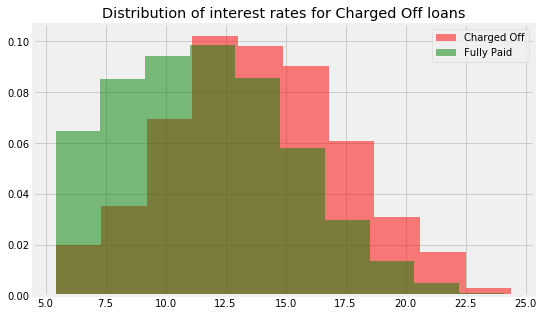

In [39]:
double_dist(loan, 'int_rate', 'Distribution of interest rates for Charged Off loans')

## Grade vs Loan Status
**Hypothesis:** For lower grades the risk of default is higher

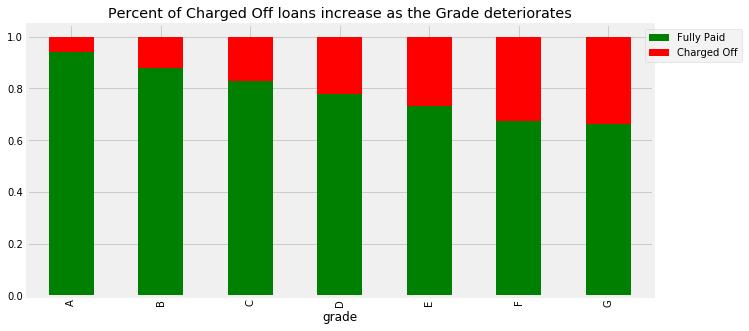

In [40]:
stacked_bar(loan, 'grade', 'Percent of Charged Off loans increase as the Grade deteriorates', size=(10, 5))

## Sub Grade vs Loan Status
**Hypothesis:** Within each grade the risk of default increases with increasing levels

### Charged Off loans count across Sub Grades

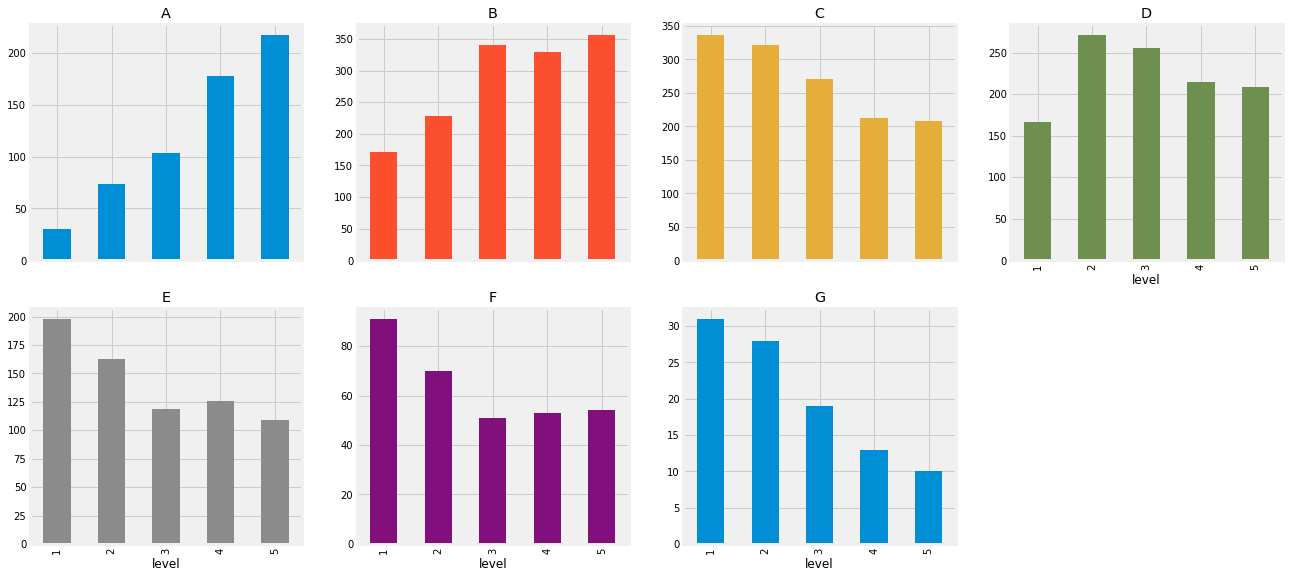

In [41]:
# Filtering only Charged Off rows and counting them across different sub grades
status_sub_grade = loan[loan['loan_status'] == 'Charged Off'].groupby('sub_grade')['id'].count().reset_index()
# Preparation for plot
status_sub_grade['grade'] = status_sub_grade['sub_grade'].str[0]
status_sub_grade['level'] = status_sub_grade['sub_grade'].str[1]
status_sub_grade = status_sub_grade.pivot_table(index='level', columns='grade', values='id')
status_sub_grade.plot(kind='bar', subplots=True, layout=(4, 4), figsize=(20, 20), legend=False)
# plt.title('Charged Off loans count across different levels within each Grade')
plt.show()

### Fully Paid loans count across Sub Grades

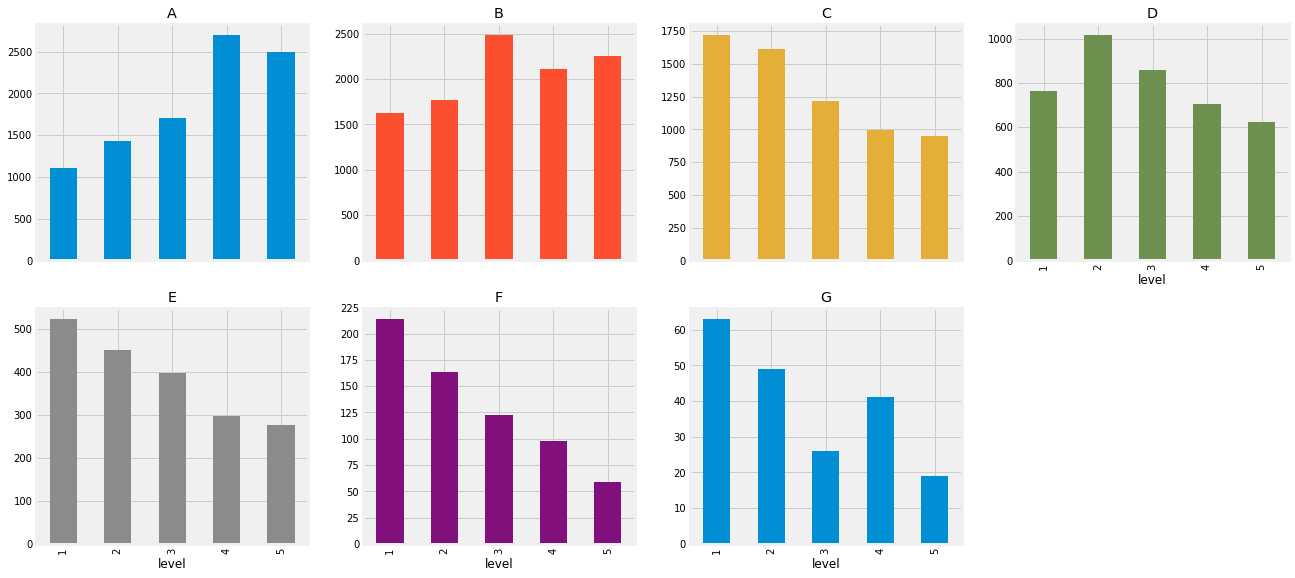

In [42]:
# Filtering only Charged Off rows and counting them across different sub grades
status_sub_grade = loan[loan['loan_status'] == 'Fully Paid'].groupby('sub_grade')['id'].count().reset_index()
# Preparation for plot
status_sub_grade['grade'] = status_sub_grade['sub_grade'].str[0]
status_sub_grade['level'] = status_sub_grade['sub_grade'].str[1]
status_sub_grade = status_sub_grade.pivot_table(index='level', columns='grade', values='id')
status_sub_grade.plot(kind='bar', subplots=True, layout=(4, 4), figsize=(20, 20), legend=False)
# plt.title('Charged Off loans count across different levels within each Grade')
plt.show()

## Home Ownership vs Loan Status
**Hypothesis:** People who default have mortgaged or rent based ownership for their home<br>
**Result:** Inconclusive

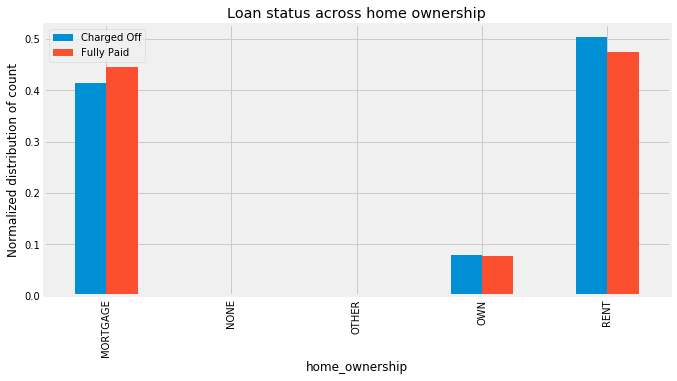

In [43]:
dual_bar(loan, 'home_ownership', 'Loan status across home ownership')

## Employment length vs Loan Status
**Hypothesis:** Risk of default decreases as employment length level increases<br>
**Result:** Mostly inconclusive, however people with 10+ years exp have slightly high risk of default

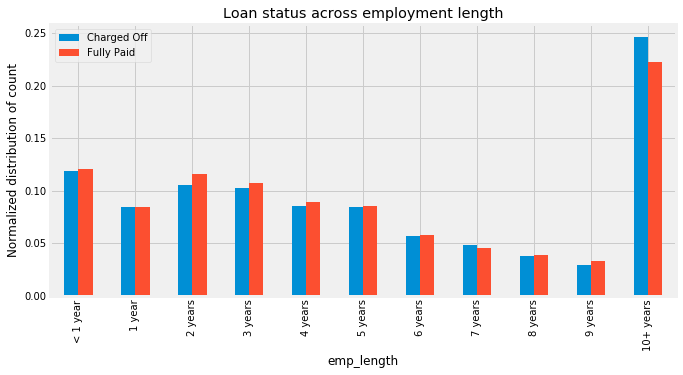

In [44]:
dual_bar(loan, 'emp_length', 'Loan status across employment length')

## Annual Income vs Loan Status
**Hypothesis:** People with high income default less<br>
**Result:** Inconclusive

In [45]:
# Median income for the two categories
loan.groupby('loan_status')['annual_inc'].median()

loan_status
Charged Off    53000.0
Fully Paid     60000.0
Name: annual_inc, dtype: float64

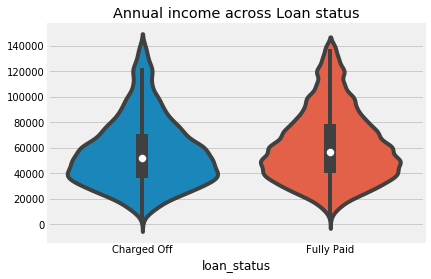

In [46]:
# Seaborn gives out warning reg scipy ver, ignoring it
import warnings
warnings.filterwarnings("ignore")
# Creating a violin plot to compare the distribution across loan status
ax = sns.violinplot(x="loan_status", y="annual_inc_treat", data=loan)
ax.set_ylabel('') 
plt.title('Annual income across Loan status')
plt.show()

## Issue Date vs Loan Status
**Hypothesis:** Loans issued during financially tough years like 2007 and 2011 will have high percentage of default
**Result:** 2007 and 2011 have slightly higher default perc than others

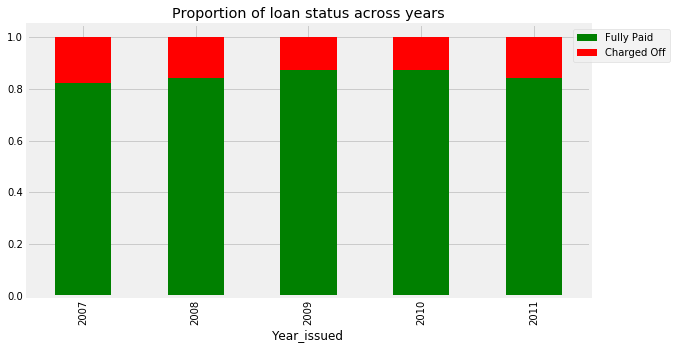

In [47]:
stacked_bar(loan, 'Year_issued', 'Proportion of loan status across years', size=(9, 5))

## Loan Purpose vs Loan Status
**Purpose:** To identify which purpose stated by the borrower as the most risky<br>
**Finding:** Small business

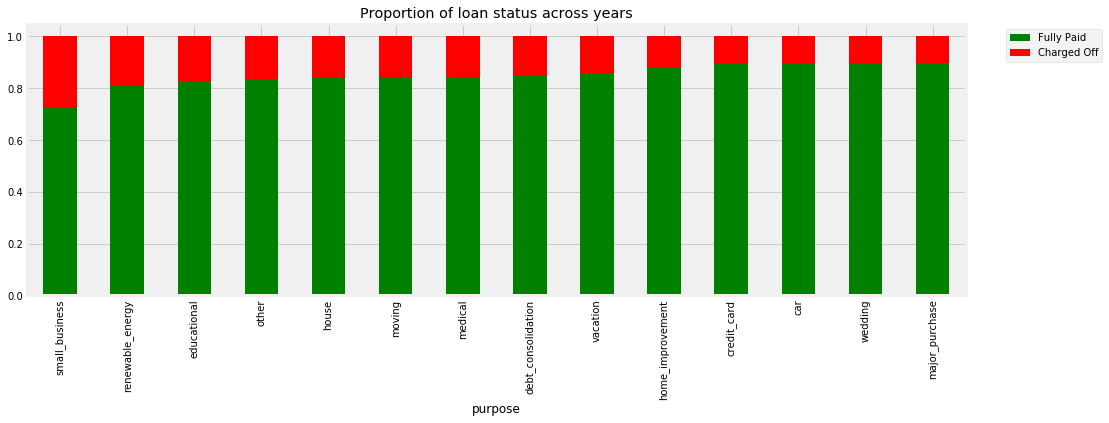

In [48]:
stacked_bar(loan, 'purpose', 'Proportion of loan status across years', 15)

## State vs Loan Status
**Purpose:** To find the most risky states<br>
**Finding:** Nebraska and Nevada

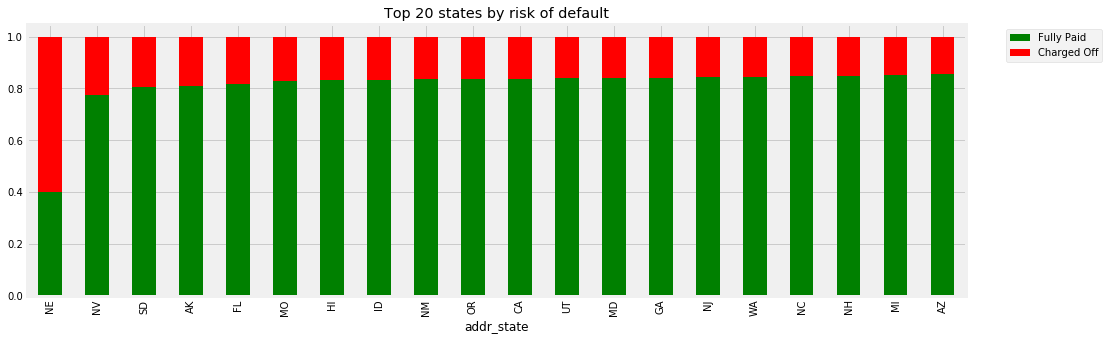

In [49]:
stacked_bar(loan, 'addr_state', 'Top 20 states by risk of default', 20)

## DTI vs Loan Status
**Hypothesis:** Increase in dti increases risk of default<br>
**Conclusion:** Inconclusive

In [50]:
loan.groupby('loan_status')['dti'].median()

loan_status
Charged Off    14.29
Fully Paid     13.20
Name: dti, dtype: float64

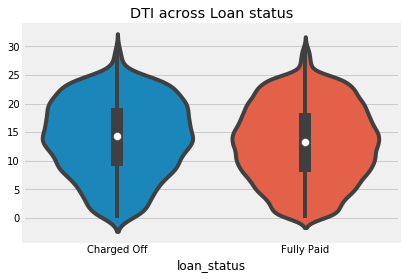

In [51]:
# Creating a violin plot to compare the distribution across loan status
ax = sns.violinplot(x="loan_status", y="dti", data=loan)
ax.set_ylabel('') 
plt.title('DTI across Loan status')
plt.show()

## Open Account vs Loan Status
**Hypothesis:** More open accounts increases risk of default<br>
**Conclusion:** Inconclusive

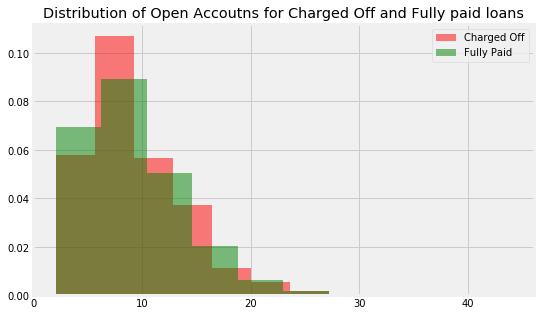

In [52]:
double_dist(loan, 'open_acc', 'Distribution of Open Accoutns for Charged Off and Fully paid loans')

# Scratch